In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
# import powerlaw
import os

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0) # default plots are app. same size as notebook
plt.style.use('ggplot')

In [2]:
import warnings

# Ignore two specific warning messages from the powerlaw package. 
# Comment these lines to show warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")

In [6]:
filepath = "/home/laal/MAG/DATA/NETWORKS/SimpleWeightEconomics2020CentralityGendered.csv"
cent_df = pd.read_csv(filepath, sep="\t")
cent_df.head()

,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank
0,3274717,8.922499e-07,1.135432e-06,60.801586,140.0,132.944440,178.0,1,16917
1,4318212,2.512850e-07,5.545155e-07,0.333333,4.0,7.666666,34.0,-1,19956
2,4561536,5.722828e-07,7.241771e-07,28.833334,166.0,96.222220,313.0,1,18352
3,4676031,4.102555e-07,7.383005e-07,8.750000,43.0,29.733334,120.0,1,16518
4,4848382,2.773767e-07,5.616168e-07,2.500000,8.0,1.500000,3.0,0,19160


## Fairness

In [35]:
def plot_group_dist(centrality_df, centrality, interval_size, max_N, protected_group, unprotected, 
                    show_unknown=True, field_name=None, na_removed=False, ax=None, global_rates=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    sorted_df = centrality_df.sort_values(by=centrality, ascending=False)
    
    if global_rates is not None:
        global_rate_protected = global_rates['protected']
        global_rate_unprotected = global_rates['unprotected']
    else:   
        global_rate_protected = sorted_df.Gender.value_counts(normalize=True)[protected_group]
        global_rate_unprotected = sorted_df.Gender.value_counts(normalize=True)[unprotected]
    
    normalizer = centrality_df.shape[0]
    
    xticks = []
    y_values = []
    y_values_unprotected = []
    y_values_unknown = []
    
    parity_x = None
    parity_pct = None
    
    for N in range(interval_size, max_N, interval_size):
        
        xticks.append((N / normalizer) * 100)
        top_n_df = sorted_df[:N]
        value_counts = top_n_df.Gender.value_counts(normalize=True)
        
        y_values.append(value_counts[protected_group] if protected_group in value_counts else 0)
        y_values_unprotected.append(value_counts[unprotected] if unprotected in value_counts else 0)
        
        abs_protected = abs(y_values[-1] - global_rate_protected)
        abs_unprotected = abs(y_values_unprotected[-1] - global_rate_unprotected)
        
        
        if parity_x is None and abs_protected <= 0.01 and abs_unprotected <= 0.01:
            parity_pct = (N / normalizer) * 100
            parity_x = N
        
        if show_unknown: y_values_unknown.append(value_counts[-1] if -1 in value_counts else 0)
    
    if show_unknown:
        global_rate_unknown = sorted_df.Gender.value_counts(normalize=True)[-1] \
        if global_rates is None else global_rates.get('unknown')
        ax.plot(xticks, y_values_unknown, '-o', label="N/A", markersize=3, color="#b8b8b8", alpha=0.2)
        ax.axhline(y=global_rate_unknown, label="Total population N/A", linestyle='--', alpha=0.8, color="#b8b8b8")
    
    
    ax.plot(xticks, y_values, '-o', label="Women", markersize=6, color="#6fc9f2")
    ax.axhline(y=global_rate_protected, label="Total population women", linestyle='--', alpha=1.0, color="#6fc9f2")
    
    
    ax.plot(xticks, y_values_unprotected, '-o', label="Men", markersize=6, color="#bd8aff")
    ax.axhline(y=global_rate_unprotected, label="Total population men", linestyle='--', alpha=1.0, color="#bd8aff")
    
    if parity_x is not None:
        ax.axvline(x=parity_pct, color="black", linestyle='-', label='Parity ($\pm$ 1 %)')
        ax.text(parity_pct - 6, 0.55, "{:,} ({} %)".format(parity_x, int(parity_pct)), rotation=90, alpha=0.8,
                fontsize=20)
    
    if global_rates is None:
        title = "Group membership in Top N rank ({})".format(centrality)
        title += ": {}".format(field_name) if field_name is not None else ""
        title += " Increment = {}".format(interval_size)
        title += ". N/A removed" if na_removed else ""
        ax.set_title(title, fontsize=12)

    ax.set_ylabel("Proportion")
    ax.set_xlabel("Top N")
    
    ax.legend()
    
    if ax is None:
        plt.show()
    
    return y_values, xticks



def plot_side_by_side(cent_df, field_name, interval=1000, figsize=(15,12), centrality="Pagerank",
                      filepath=None):
    idx = 0
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=figsize, sharex=False, sharey=True)
    axs = list(axs.flatten())
    
    labelsize = 28
    
    plt.rcParams['axes.labelsize'] = 16
    
    global_rates = {
        'protected': cent_df.Gender.value_counts(normalize=True)[0],
        'unprotected': cent_df.Gender.value_counts(normalize=True)[1],
        'unknown': cent_df.Gender.value_counts(normalize=True)[-1]
    }
    
    cent_df.sort_values(by=centrality, ascending=False, inplace=True)
    
    plot_group_dist(cent_df, centrality, 
                    interval_size=interval, 
                    max_N=len(cent_df), 
                    protected_group=0, 
                    unprotected=1,
                    field_name=field_name, 
                    ax=axs[0], global_rates=global_rates)
    
    axs[0].set_title("Top 100 % of N = {:,} \n Increment = {}".format(cent_df.shape[0], interval), 
                     fontsize=labelsize - 3, color='#363534')
    centrality_format = r"$\bf{" + centrality.replace(" ", "\ ") + "}$"
    
    axs[0].set_ylabel( centrality_format + "\nGender prop. in top N", fontsize=labelsize + 2)
    
    if centrality == 'PageRank':
        leg = axs[0].legend(fontsize=labelsize, loc='lower right', ncol=7, markerscale=4, bbox_to_anchor=(-1.05, 1.2), 
                             facecolor='white')
        leg.set_visible(True)
        
        for line in leg.get_lines():
            line.set_linewidth(8.0)
        
    else:
        axs[0].legend(fontsize=labelsize - 6, loc='lower right').set_visible(False)
    
    # axs[0].set_yticklabels(axs[0].get_yticklabels(),fontsize=labelsize)
    axs[0].tick_params(axis='y', labelsize=labelsize + 6)
    
    axs[0].set_ylim(-0.05, 1.05)
    # normalize x-axis
    #axs[0].set_xticks( axs[0].get_xticks() / axs[0].get_xticks().max() )
    
    #axs[2].get_xticks() / axs[1].get_xticks().max()
    #axs[2].get_xticks() / axs[1].get_xticks().max()
    
    
    
    cent_df_filtered = cent_df.query("Gender != -1")
    
    global_rates = {
        'protected': cent_df_filtered.Gender.value_counts(normalize=True)[0],
        'unprotected': cent_df_filtered.Gender.value_counts(normalize=True)[1],
    }
    
    y, x = plot_group_dist(cent_df_filtered, centrality, 
                           interval_size=interval,
                           max_N=len(cent_df_filtered), 
                           protected_group=0, 
                           unprotected=1, 
                           show_unknown=False,
                           na_removed=True,
                           field_name=field_name,
                           ax=axs[1],
                           global_rates=global_rates)
    axs[1].set_title("Top 100 % of N = {:,}\n Increment = {}. N/A removed".format(cent_df_filtered.shape[0], 
                                                                               interval), fontsize=labelsize - 3,
                    color='#363534')
    axs[1].set_ylabel(None)
    axs[1].legend().set_visible(False)
    
    # 10 %
    cent_df_filtered_ten = cent_df_filtered[:int(cent_df_filtered.shape[0] * 0.1)]
    y, x = plot_group_dist(cent_df_filtered_ten, centrality, 
                           interval_size=100,
                           max_N=len(cent_df_filtered_ten), 
                           protected_group=0, 
                           unprotected=1, 
                           show_unknown=False,
                           na_removed=True,
                           field_name=field_name,
                           ax=axs[2],
                           global_rates=global_rates)
    axs[2].set_title("Top 10 % of N = {:,}\n Increment = {}. N/A removed".format(cent_df_filtered.shape[0],
                                                                               100), 
                     fontsize=labelsize - 3, color='#363534')
    axs[2].set_ylabel(None)
    axs[2].legend().set_visible(False)
    
    
    cent_df_filtered_one = cent_df_filtered[:int(cent_df_filtered.shape[0] * 0.01)]
    y, x = plot_group_dist(cent_df_filtered_one, centrality, 
                           interval_size=10,
                           max_N=len(cent_df_filtered_one), 
                           protected_group=0, 
                           unprotected=1, 
                           show_unknown=False,
                           na_removed=True,
                           field_name=field_name,
                           ax=axs[3],
                           global_rates=global_rates)
    
    axs[3].set_title("Top 1 % of N = {:,} \n Increment = {}. N/A removed".format(cent_df_filtered.shape[0], 10), 
                     fontsize=labelsize - 3, color='#363534')
    axs[3].set_ylabel(None)
    axs[3].legend(fontsize=13, loc='right').set_visible(False)
    
    plt.suptitle("Gender distribution in top N rankings in " + r"$\bf{" + field_name + "}$", 
                 fontsize=labelsize + 4, color='#363534')
    plt.tight_layout()
    
    maxval = cent_df.shape[0]
    
    
    xticks = []
    for tick in axs[2].get_xticklabels()[1:-1]:
        tick.set_text("{}".format(int(tick._x / 10)))
        xticks.append(tick)
    axs[2].set_xticklabels(xticks, fontsize=labelsize)
    axs[2].set_xlabel('% of top N', fontsize=labelsize)
    
    
    xticks = []
    for tick in axs[3].get_xticklabels()[1:-1]:
        tick.set_text("{0:.1f}".format(tick._x / 100))
        xticks.append(tick)

    axs[3].set_xticklabels(xticks, fontsize=labelsize)
    axs[3].set_xlabel('% of top N', fontsize=labelsize)
    
    axs[3].labelsize = 30

    
    for i in range(4):
        axs[i].set_xticks([0. ,  20,  40,  60,  80,  100])
        axs[i].set_xlabel('% of top N', fontsize=labelsize)
        axs[i].tick_params(axis='x', labelsize=labelsize + 10, rotation=90)
    
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.2)
        
    return axs



<ipython-input-35-a5e5c9192636>:199: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
<ipython-input-35-a5e5c9192636>:208: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
<ipython-input-35-a5e5c9192636>:217: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


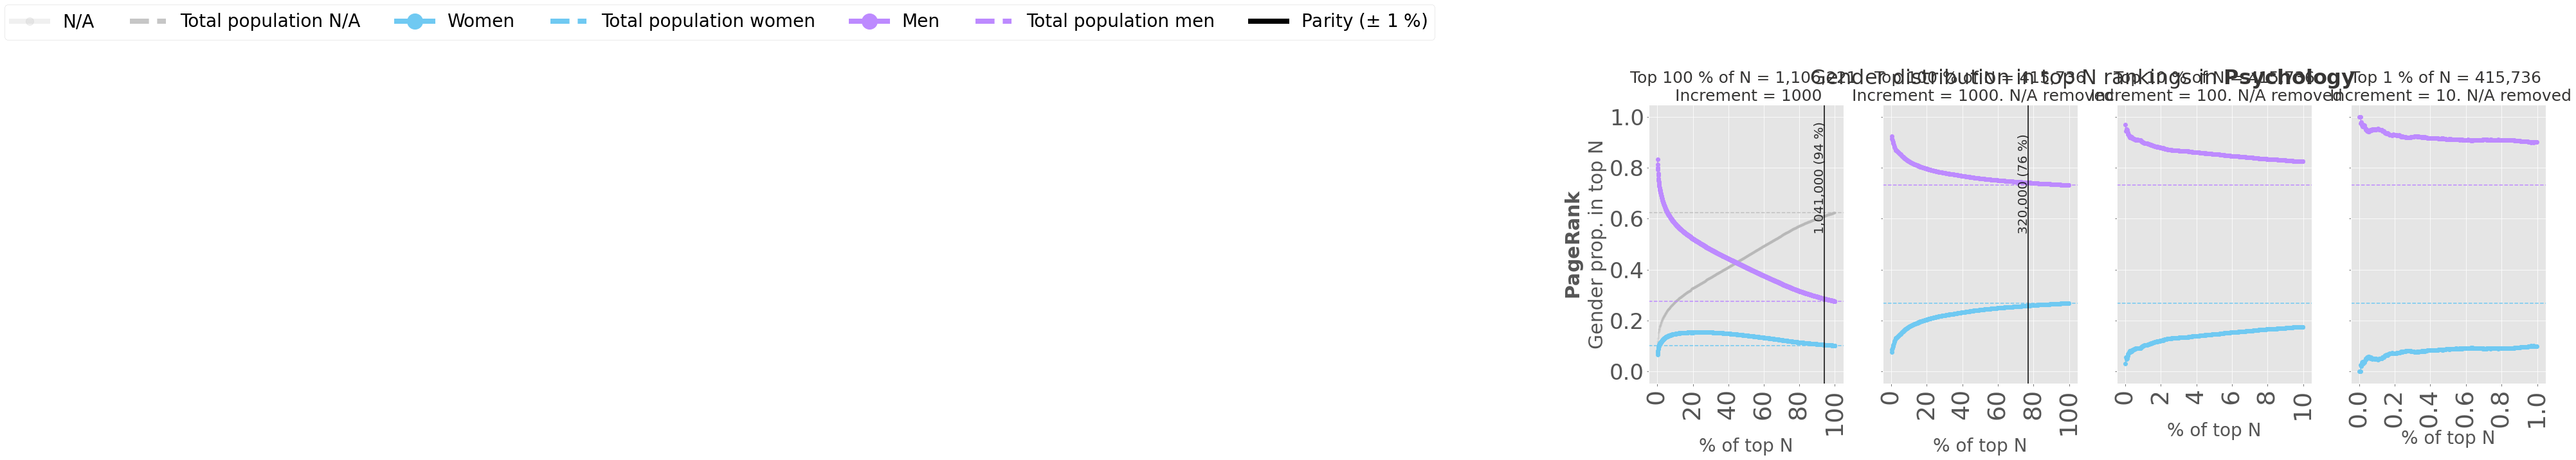

In [36]:
axs = plot_side_by_side(cent_df, 'Psychology', interval=1000, 
                        figsize=(25,8), centrality="PageRank", filepath="test_graph.png")

In [38]:
axs[0].get_yticklabels()

[Text(0, -0.2, ''),
 Text(0, 0.0, ''),
 Text(0, 0.2, ''),
 Text(0, 0.4000000000000001, ''),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.8, ''),
 Text(0, 1.0000000000000002, ''),
 Text(0, 1.2000000000000002, '')]

In [31]:
axs[0].get_xticks() / axs[0].get_xticks().max()

array([-0.16666667,  0.        ,  0.16666667,  0.33333333,  0.5       ,
        0.66666667,  0.83333333,  1.        ])

In [32]:
axs[0].get_xticks()

array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2])

In [20]:
axs[2].get_xticks() / axs[1].get_xticks().max()

array([-0.01666667,  0.        ,  0.01666667,  0.03333333,  0.05      ,
        0.06666667,  0.08333333,  0.1       ])

In [21]:
cent_df[:10]

,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank
1895323,968460832,0.001325,0.000528,19650.7770,17658.0,3.000000,3.000000,1,11308
1202609,2137065126,0.001166,0.000684,49866.9960,54321.0,3666.764200,3666.764200,1,11038
125279,467622467,0.000947,0.000436,22329.7500,27923.0,19.166666,19.166666,0,11565
1336062,2490080893,0.000879,0.000300,15904.7740,13884.0,1159.166600,1159.166600,-1,12048
1690847,1982301990,0.000768,0.000328,20830.6370,24780.0,5633.717000,5633.717000,-1,12042
577524,355673734,0.000717,0.000171,3242.3833,4578.0,27.500000,27.500000,-1,12201
2020262,1969121271,0.000683,0.000157,4560.8477,6147.0,214.250000,214.250000,1,12619
1698296,2157867866,0.000659,0.000352,11459.1980,25321.0,31.500000,31.500000,1,12516
334913,2026186952,0.000618,0.000274,10341.3920,19441.0,382.833340,382.833340,1,12640
256964,2134451896,0.000605,0.000241,12156.9890,17248.0,143.683330,143.683330,1,11875


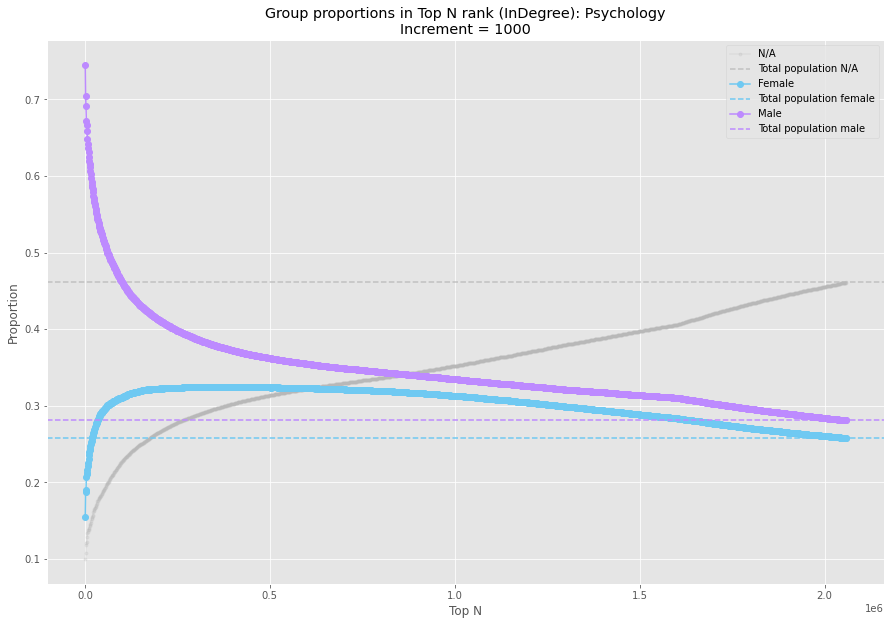

In [21]:
y, x = plot_group_dist(cent_df, 'InDegree', interval_size=1000, max_N=len(cent_df), protected_group=0, unprotected=1,
                       field_name="Psychology")

In [19]:
cent_df_filtered = cent_df.query("Gender != -1")

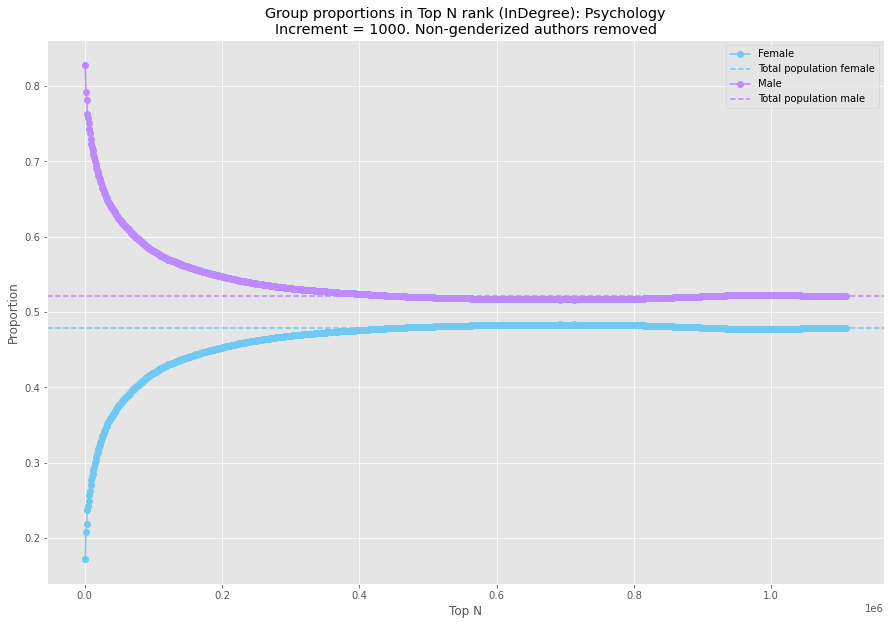

In [20]:
y, x = plot_group_dist(cent_df_filtered, 'InDegree', interval_size=1000, max_N=len(cent_df_filtered), 
                       protected_group=0, 
                       unprotected=1, 
                       show_unknown=False,
                       na_removed=True,
                       field_name="Psychology")

In [9]:
def read_author_metadata(fos_id=162324750):
    base_destination = "/home/laal/MAG/DATA/AuthorMetadataField.csv"
    
    columns = ['AuthorId', 'FieldOfStudyId', 'Gender', 'MinAffiliationRank', 'NumPapers', 'MinPubDate', 'MaxPubDate', 'PubsPerYear']
    
    author_df = pd.DataFrame()
    
    for file in os.listdir(base_destination):
        if file.endswith('.csv'):
            df = pd.read_csv(base_destination + "/" + file, names=columns, sep="\t")
            author_df = pd.concat([author_df, df.query("FieldOfStudyId == {}".format(fos_id))])
    
    # parse datetimes
    author_df['MinPubDate'] = pd.to_datetime(author_df['MinPubDate'])
    author_df['MaxPubDate'] = pd.to_datetime(author_df['MaxPubDate'])
    
    author_df['MinPubYear'] = author_df['MinPubDate'].apply(lambda x: x.year)
    author_df['MaxPubYear'] = author_df['MaxPubDate'].apply(lambda x: x.year)
    
    return author_df



def plot_all_fields(centrality, interval=1000, num_papers_min=None):
    
    field_ids = {
        "Psychology": 15744967,
        "Economics": 162324750, 
        "Mathematics": 33923547,
        "Chemistry": 185592680,
    }
    
    field_mapping = {
        "Psychology": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightPsychology2020CentralityGendered.csv",
        "Economics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightEconomics2020CentralityGendered.csv", 
        "Mathematics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightMathematics2020CentralityGendered.csv",
        "Chemistry": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightChemistry2020CentralityGendered.csv",
    }
    
    for field_name, fpath in field_mapping.items():
        
        cent_df = pd.read_csv(fpath, sep="\t")
        cent_df['MAG Rank'] = cent_df['Rank'].apply(lambda x: x*-1)
        
        if centrality == 'Rank':
            centrality = 'MAG Rank'
                
        if num_papers_min is not None:
            
            author_meta = read_author_metadata(fos_id=field_ids[field_name])
            
            authors = author_meta.query("NumPapers > {}".format(num_papers_min))['AuthorId'].values
            
            cent_df = cent_df[cent_df.AuthorId.isin(authors)]
            
                
        plot_side_by_side(cent_df, field_name, interval=1000, figsize=(25,8), centrality=centrality)
        

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


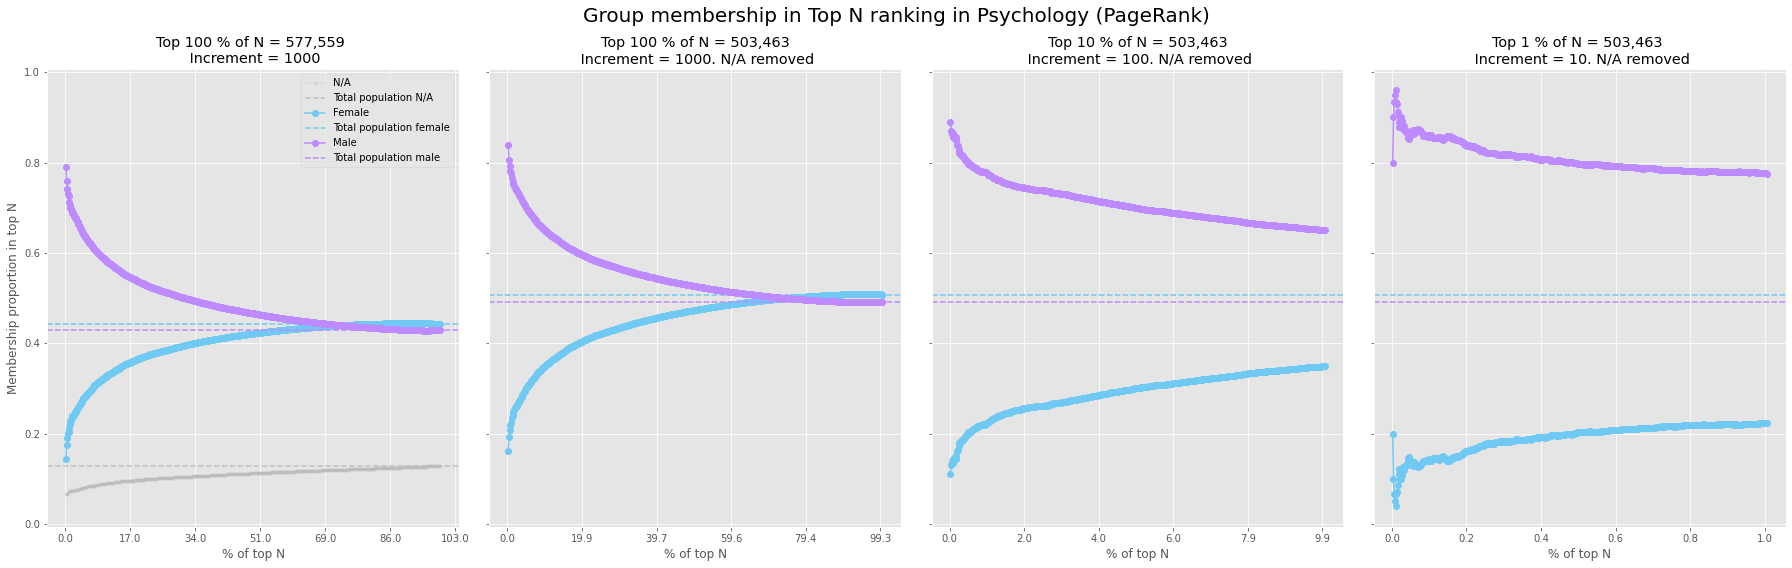

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


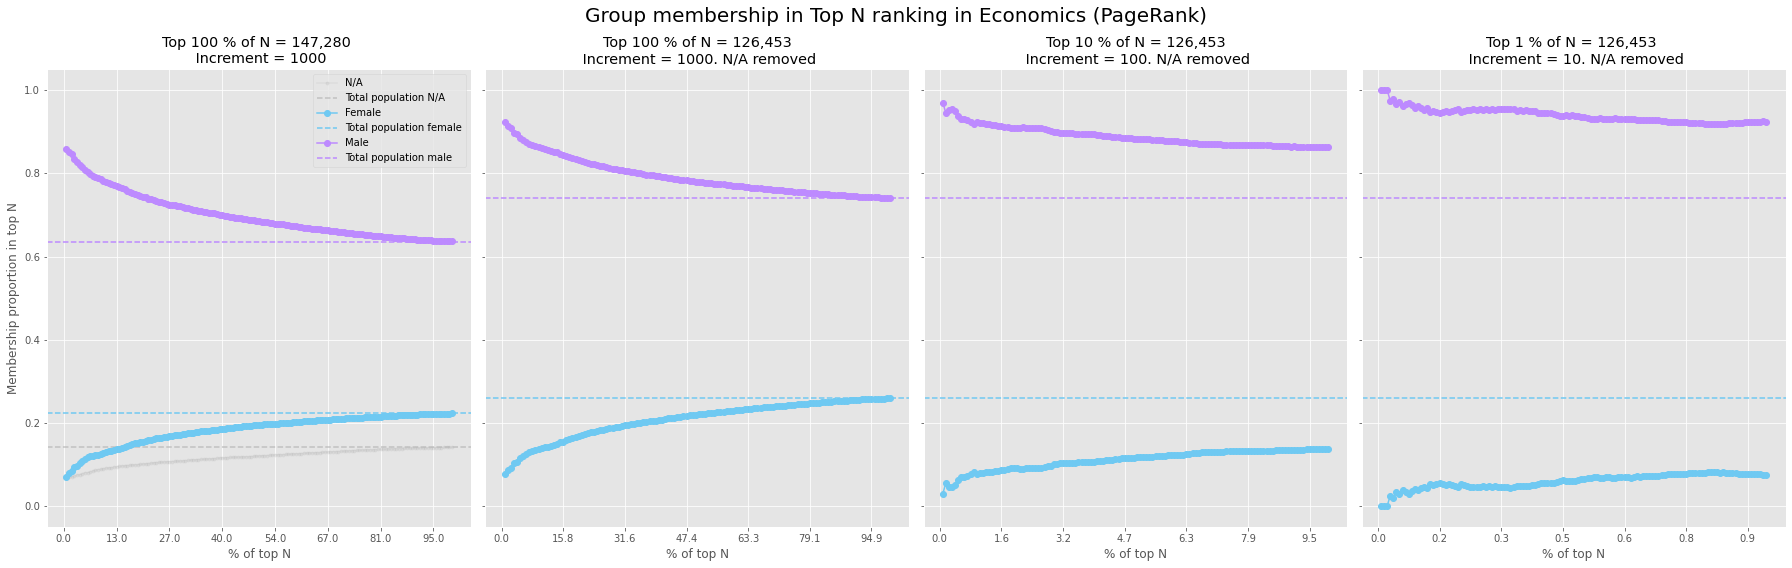

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


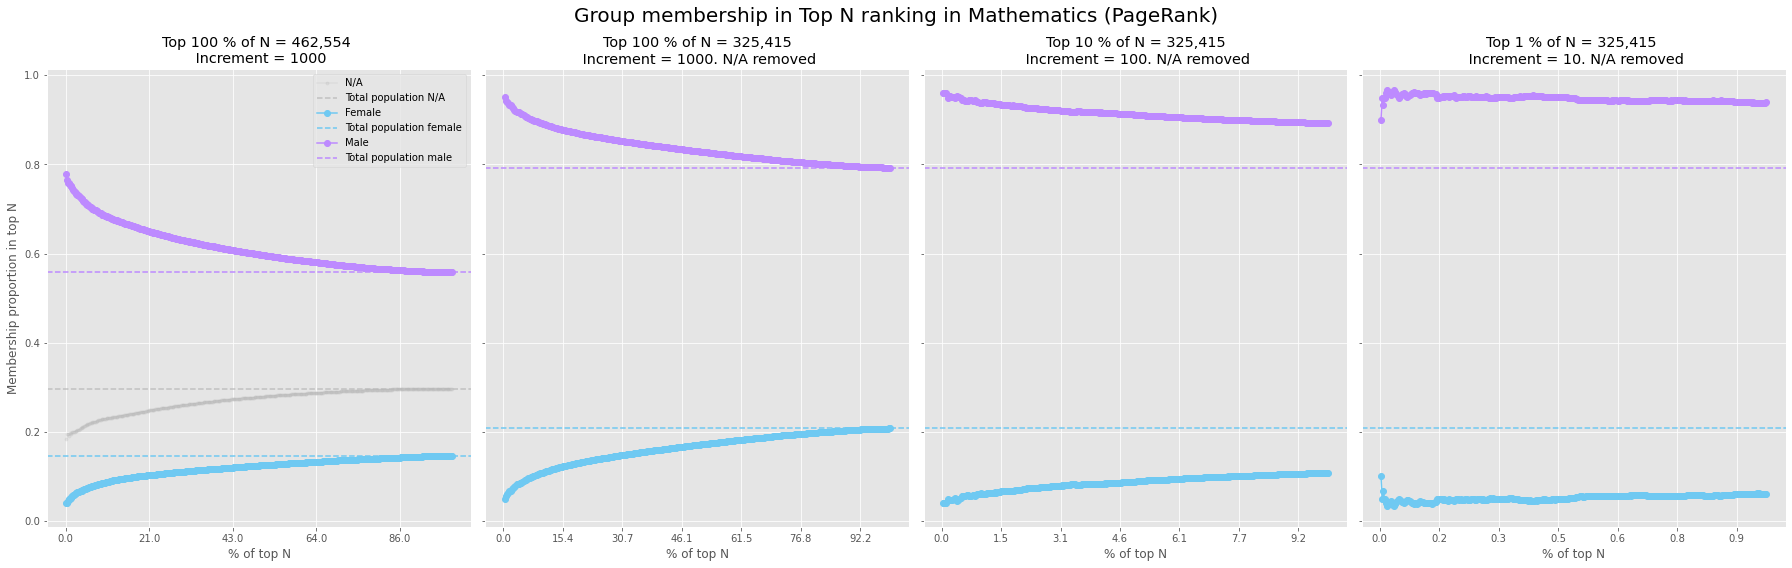

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


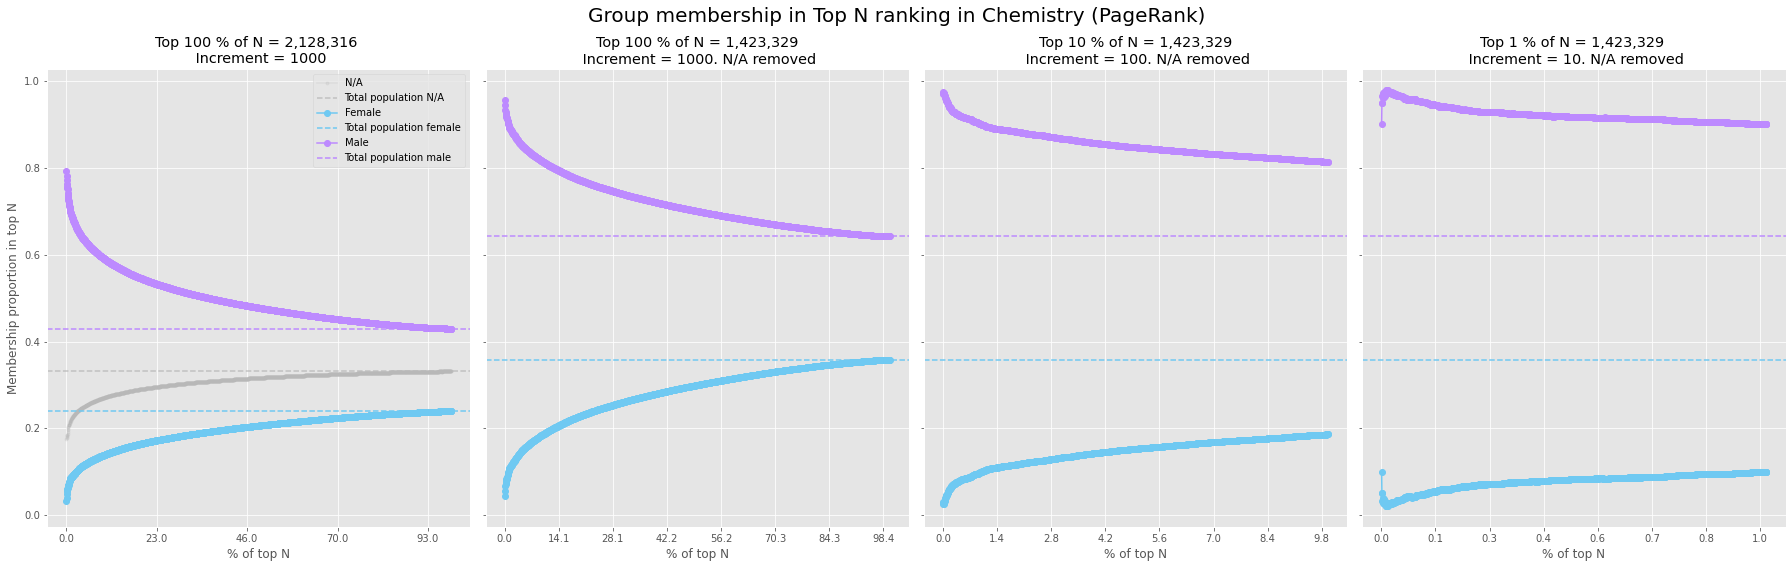

In [10]:
plot_all_fields('PageRank', 1000, num_papers_min=1)

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


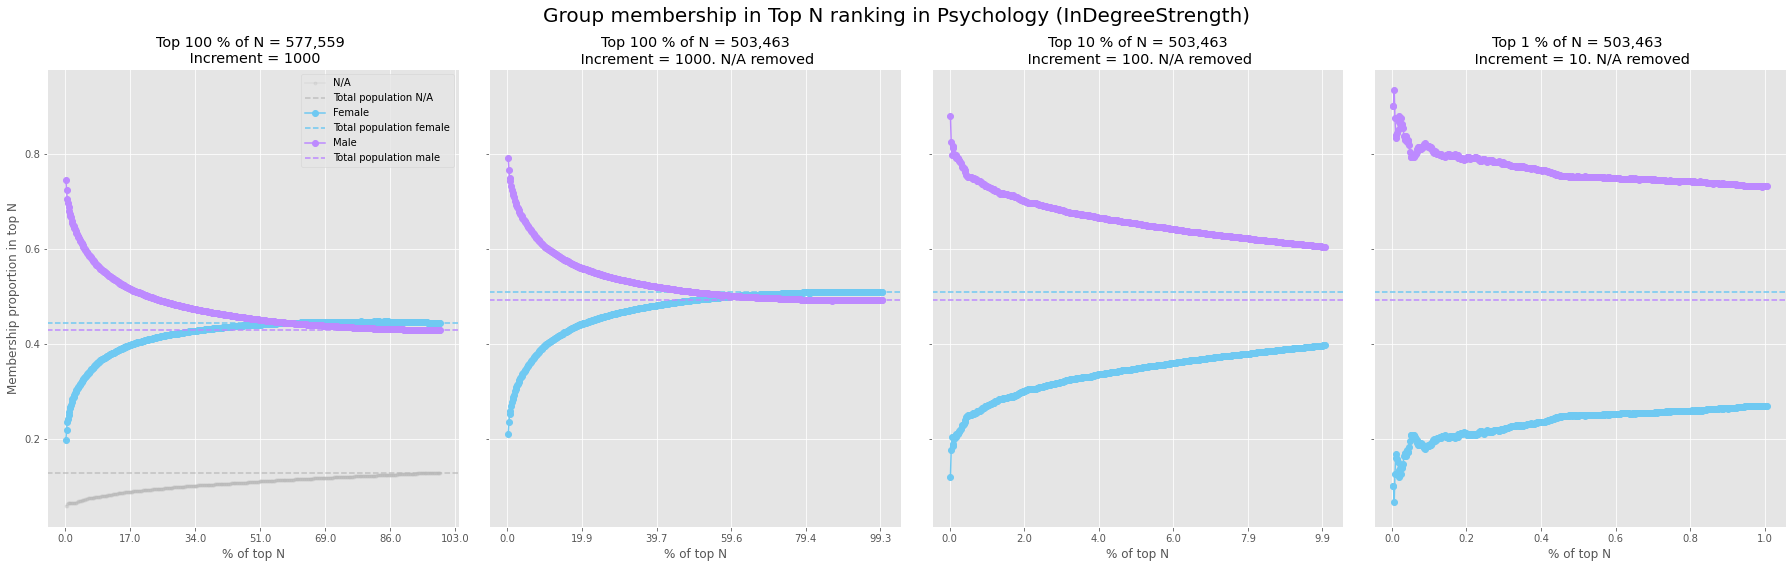

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


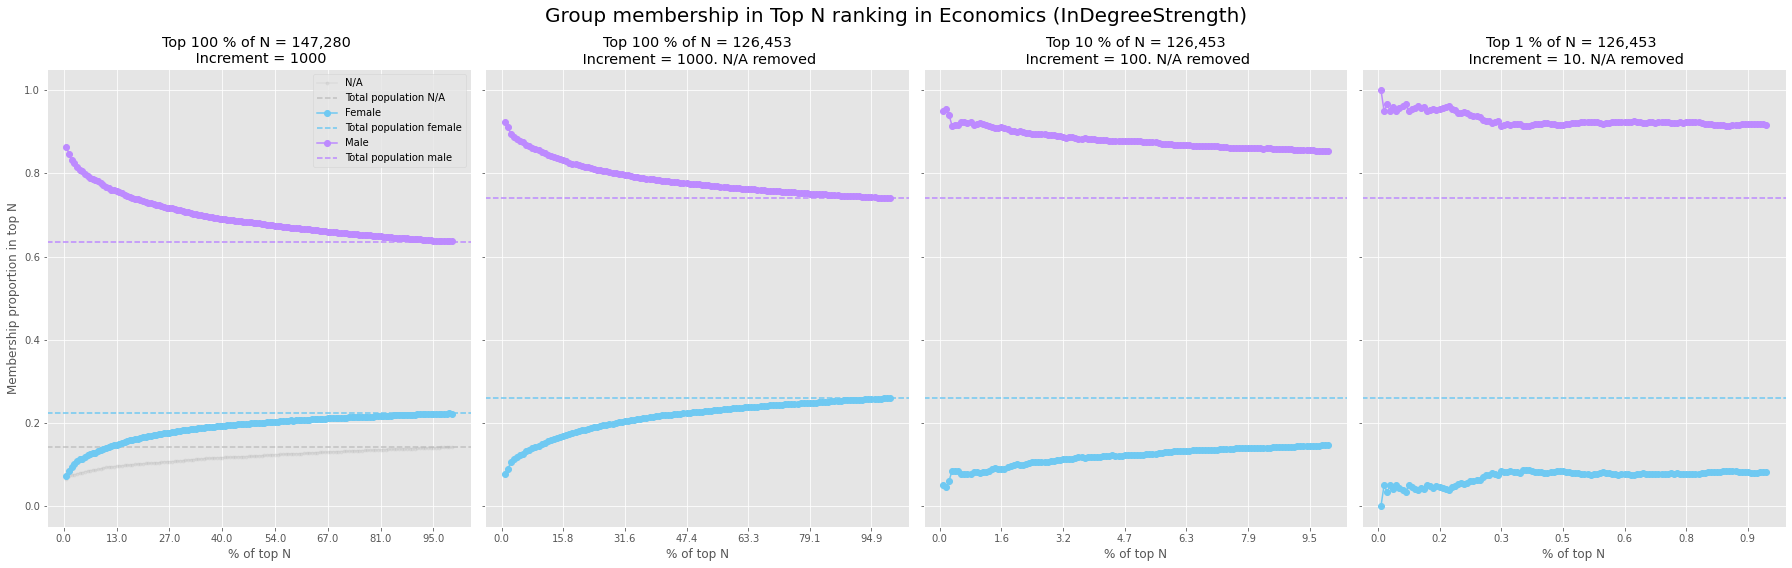

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


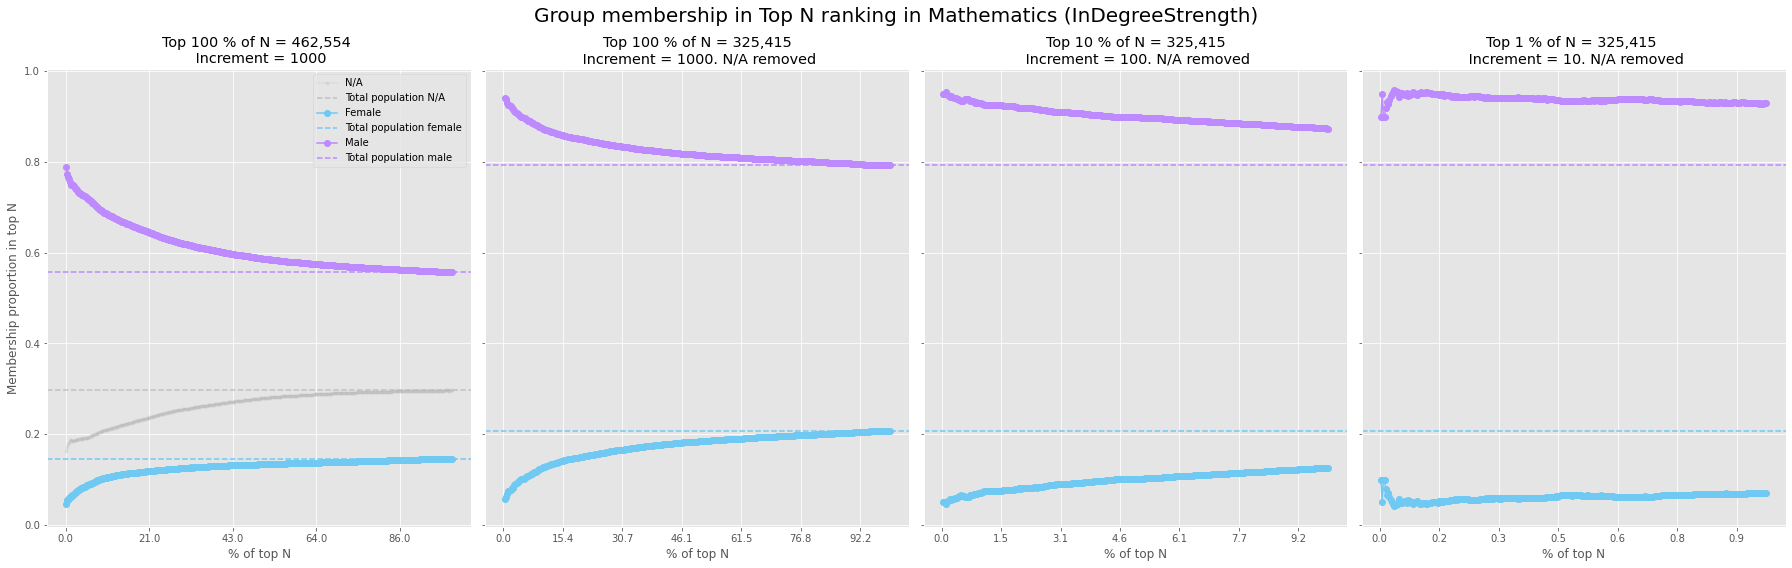

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


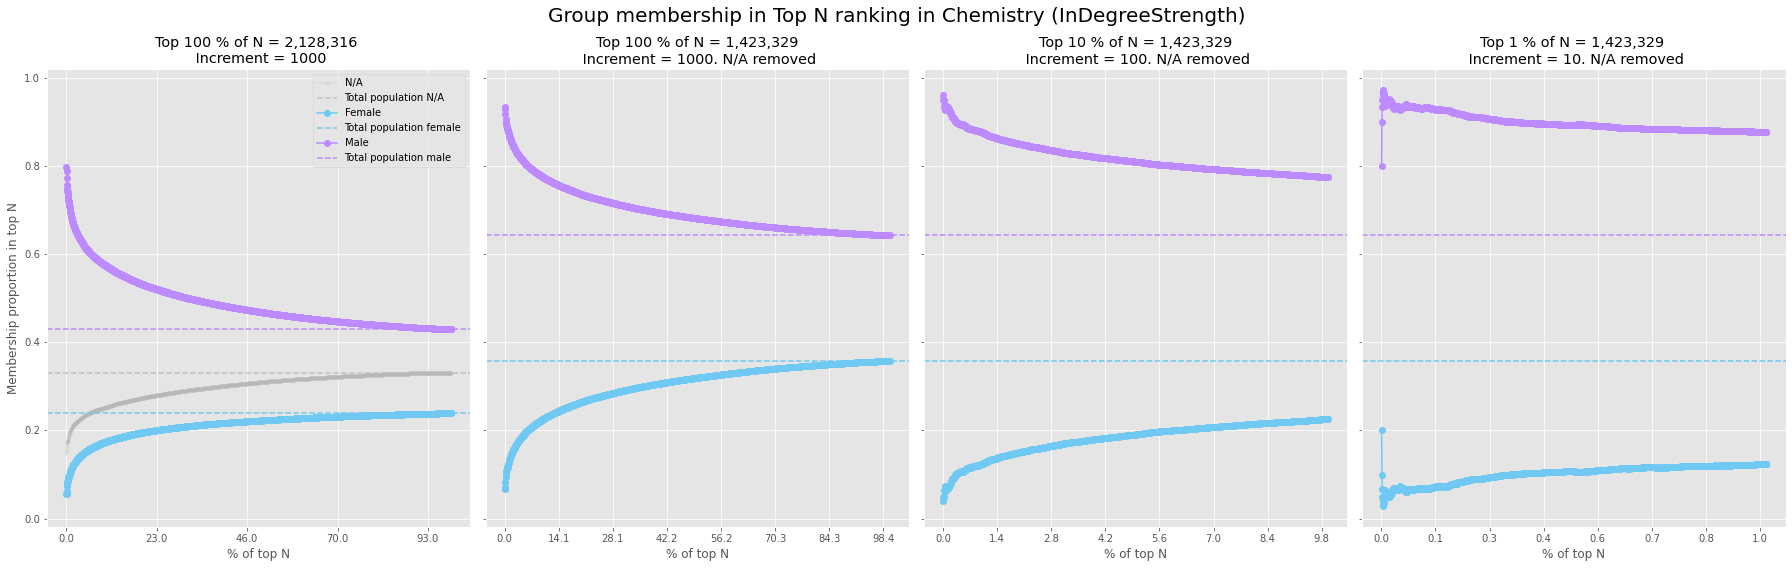

In [11]:
plot_all_fields('InDegreeStrength', 1000, num_papers_min=1)

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


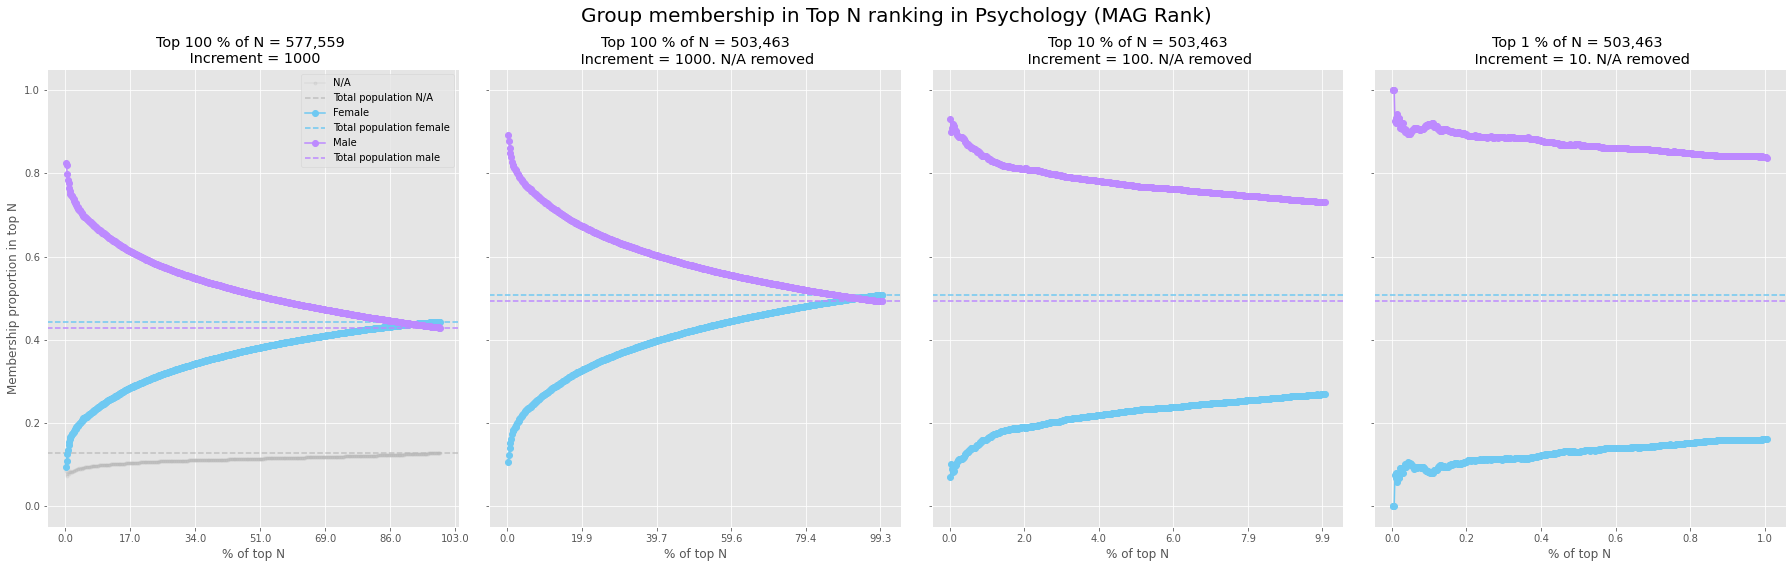

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


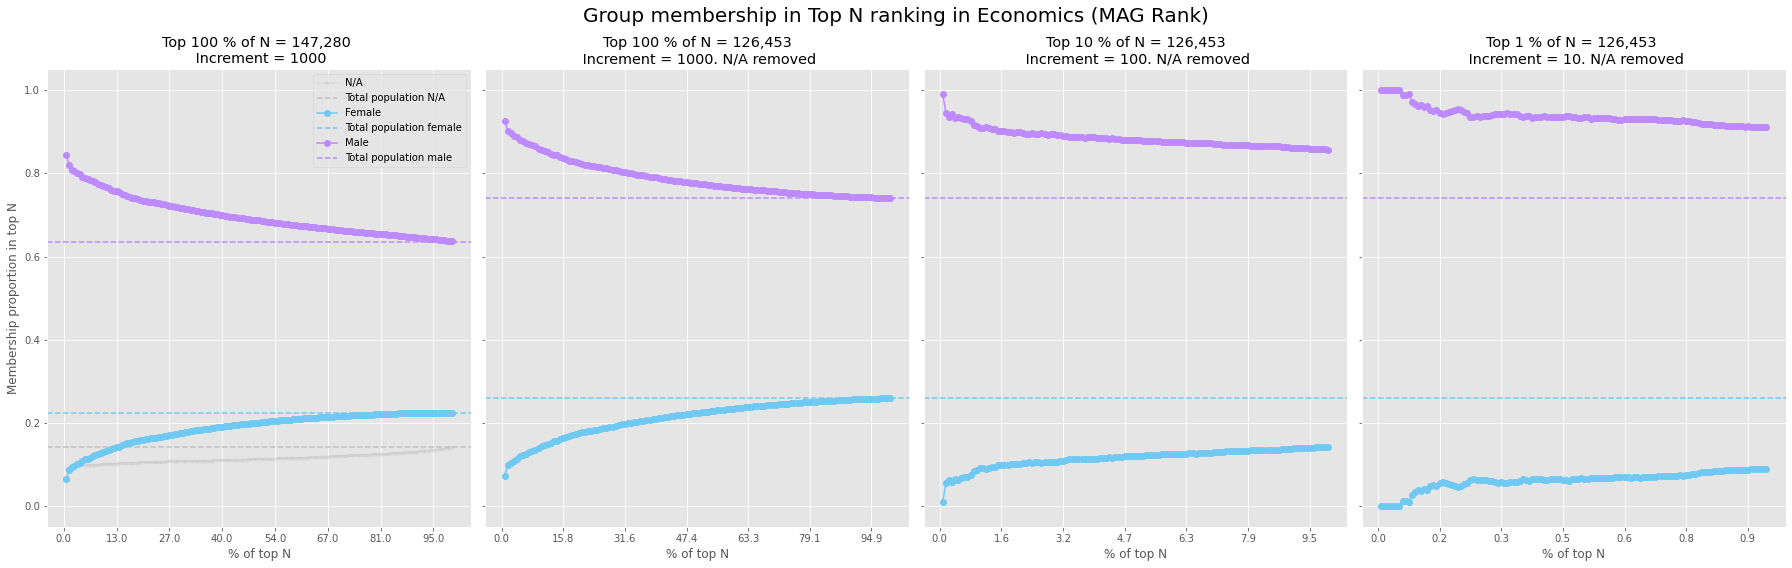

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


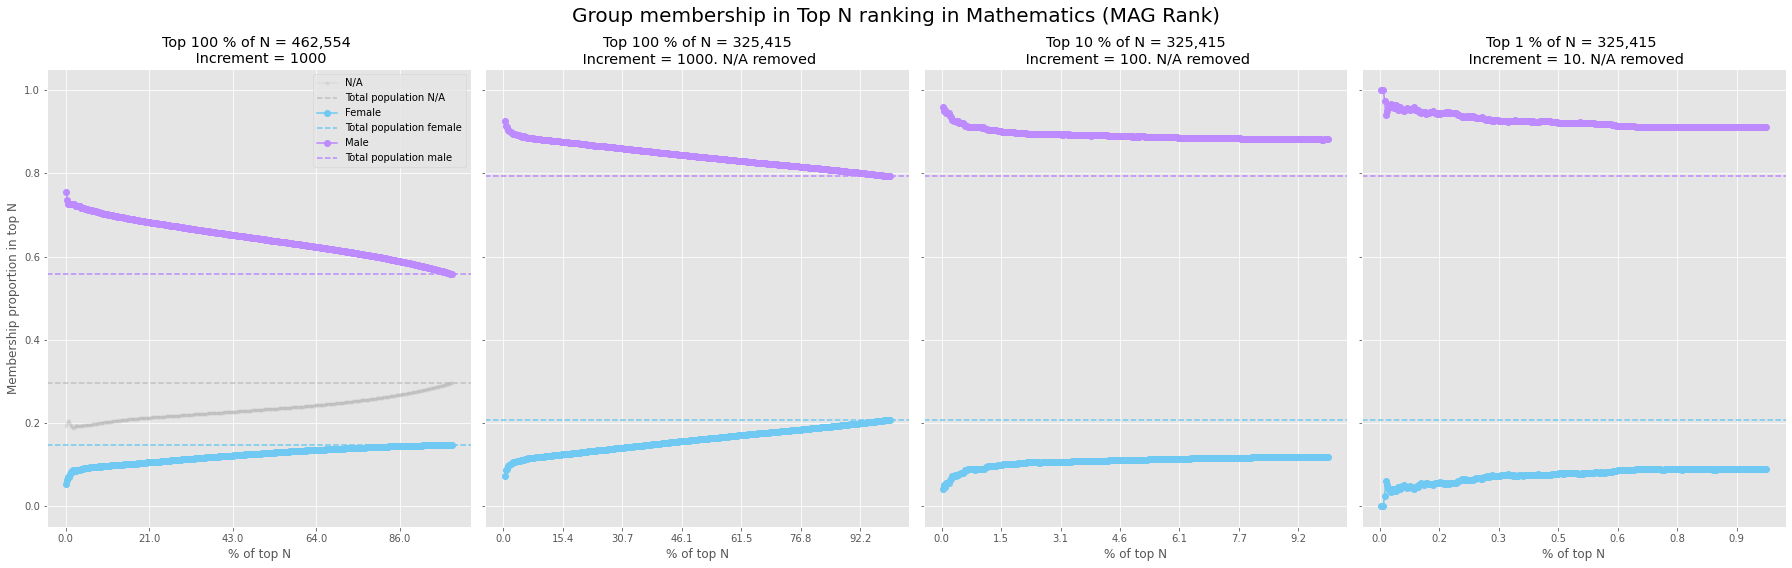

<ipython-input-4-a4f12bdcfb85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cent_df.sort_values(by=centrality, ascending=False, inplace=True)
<ipython-input-4-a4f12bdcfb85>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks)
<ipython-input-4-a4f12bdcfb85>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks)


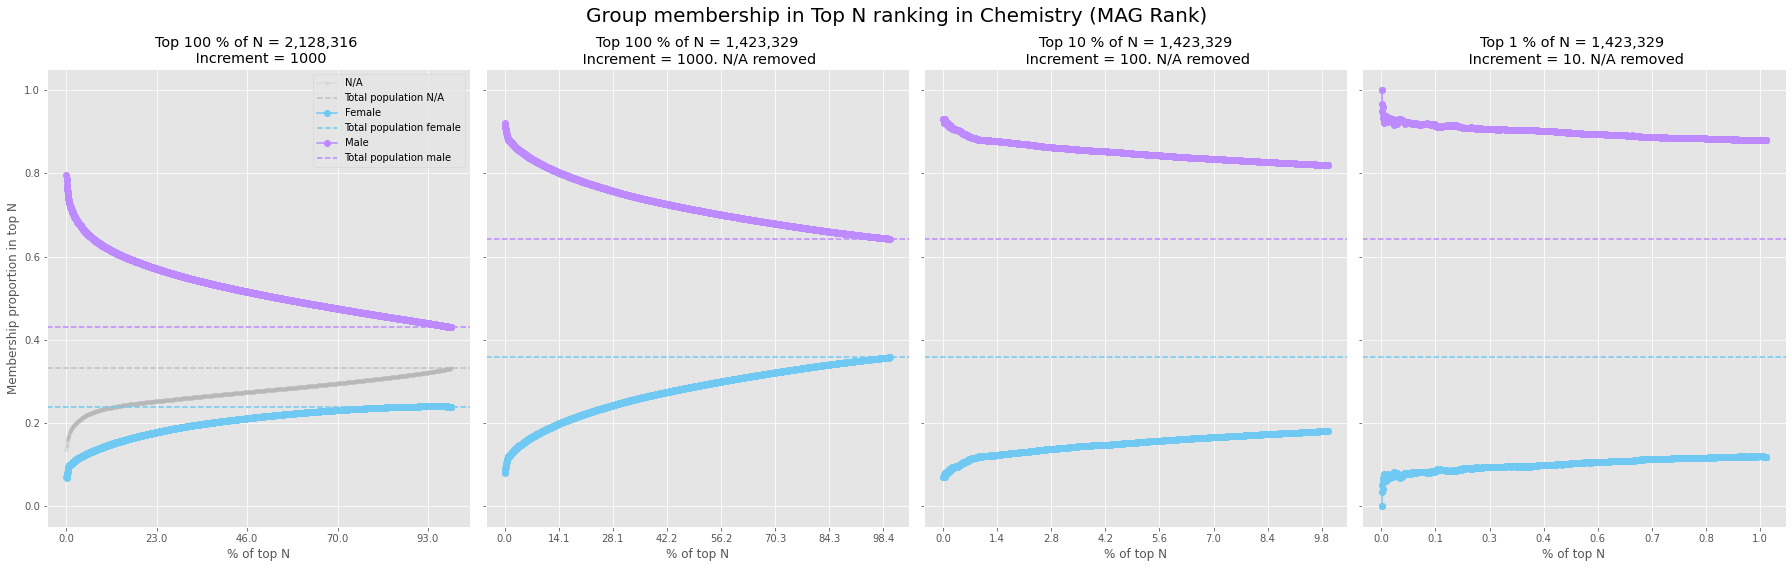

In [12]:
plot_all_fields('Rank', 1000, num_papers_min=1)

## Fairness measure comparison

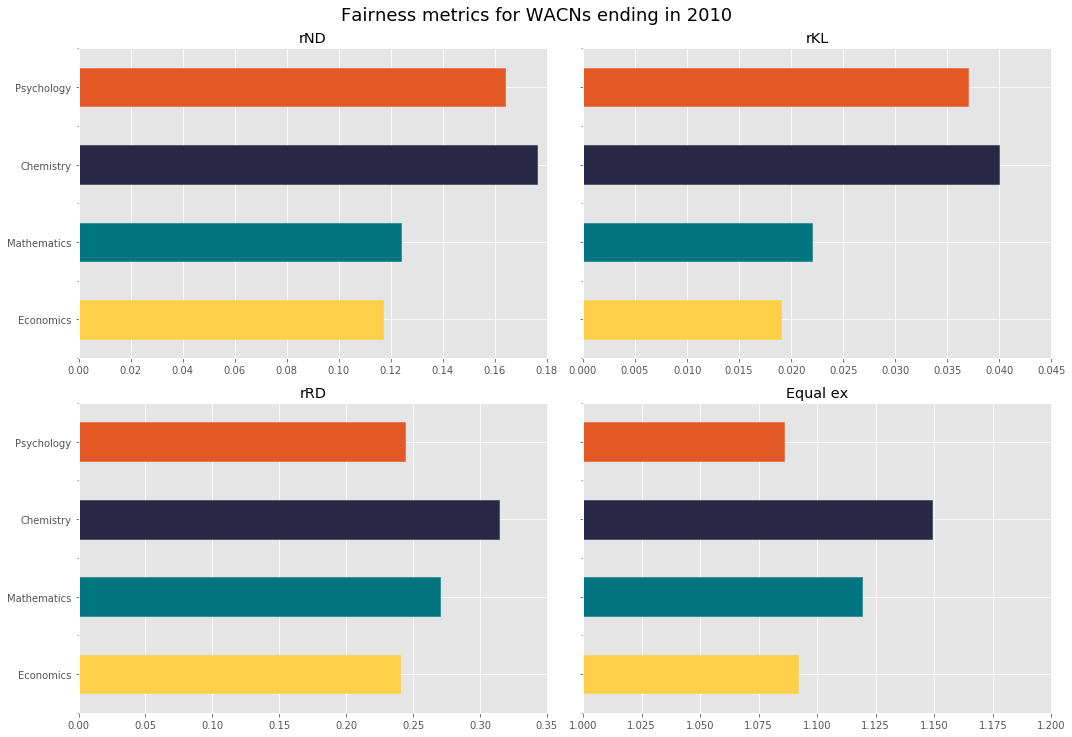

In [55]:
data = [[0.117, 0.019, 0.240, 1.092],
        [0.124, 0.022, 0.270, 1.119], 
        [0.176, 0.040, 0.314, 1.149],
        [0.164, 0.037, 0.244, 1.086]]

names = ['Economics', 'Mathematics', 'Chemistry', 'Psychology']

xlims = [(0, 0.18), (0, 0.045), (0, 0.35), (1, 1.2)]

fairness_df = pd.DataFrame(data, columns=['rND', 'rKL', 'rRD', 'Equal ex'], 
                           index=names)

output = fairness_df.plot(kind='barh', subplots=True, layout=(2,2), sharex=False,
                         legend=None, sharey=True)

colors = ['#fed049', '#007580', '#282846', '#e45826']


for index, chart in enumerate(output.flatten()):    
    for idx, patch in enumerate(chart.patches):
        patch.set_color(colors[idx])
    
    chart.set_xlim(xlims[index])
        
plt.suptitle("Fairness metrics for WACNs ending in 2010", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

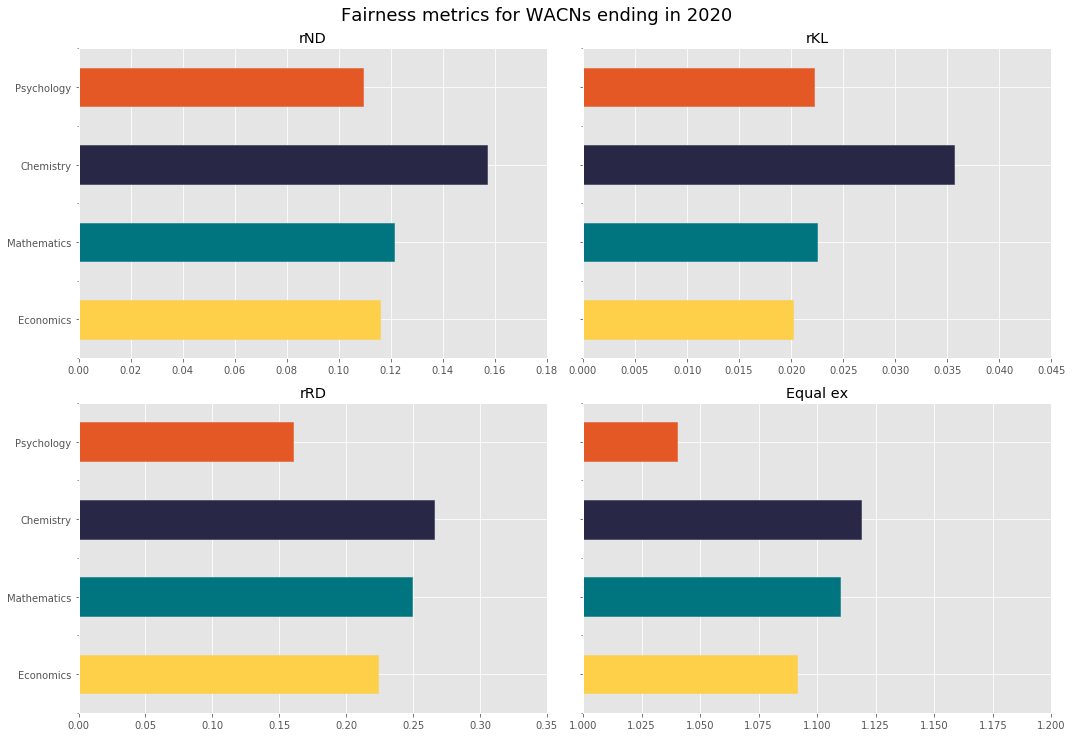

In [56]:
data = [[0.11593, 0.02018, 0.223787, 1.09122],
        [0.121057, 0.022437, 0.24905, 1.1097050], 
        [0.156861, 0.035671, 0.2654512,1.11853],
        [0.10930,0.02223, 0.16049, 1.04017]]

names = ['Economics', 'Mathematics', 'Chemistry', 'Psychology']

xlims = [(0, 0.18), (0, 0.045), (0, 0.35), (1, 1.2)]

fairness_df = pd.DataFrame(data, columns=['rND', 'rKL', 'rRD', 'Equal ex'], 
                           index=names)

output = fairness_df.plot(kind='barh', subplots=True, layout=(2,2), sharex=False,
                         legend=None, sharey=True)

colors = ['#fed049', '#007580', '#282846', '#e45826']


for index, chart in enumerate(output.flatten()):    
    for idx, patch in enumerate(chart.patches):
        patch.set_color(colors[idx])
    
    chart.set_xlim(xlims[index])
        
plt.suptitle("Fairness metrics for WACNs ending in 2020", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

## Zero in-degree

In [15]:
def zero_indegree():
    
    field_mapping = {
        "Psychology": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightPsychology2020CentralityGendered.csv",
        "Economics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightEconomics2020CentralityGendered.csv", 
        "Mathematics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightMathematics2020CentralityGendered.csv",
        "Chemistry": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightChemistry2020CentralityGendered.csv",
    }
    
    for field_name, fpath in field_mapping.items():
        
        cent_df = pd.read_csv(fpath, sep="\t").query("Gender != -1")
        cent_df['MAG Rank'] = cent_df['Rank'].apply(lambda x: x * -1)
        
        zero = cent_df[cent_df.InDegreeStrength <= 0]
        print("Proportion with 0 in-degre strength in {}: {} / {} = {}"
             .format(field_name, len(zero), len(cent_df), len(zero) / len(cent_df)))

In [16]:
zero_indegree()

Proportion with 0 in-degre strength in Psychology: 157674 / 1623660 = 0.09711023243782566
Proportion with 0 in-degre strength in Economics: 57760 / 415736 = 0.13893432370542844
Proportion with 0 in-degre strength in Mathematics: 194932 / 969237 = 0.2011190245523025
Proportion with 0 in-degre strength in Chemistry: 317841 / 3935075 = 0.08077126865434585


## Visualization of slices


In [81]:
import numpy as np


def plot_slices(figsize=(12,8)):

    colors = {
    'Psychology': '#3f2cfd',
    'Chemistry' : '#282846',
    'Mathematics': '#007580',
    'Economics': '#fed049'
    }
    
    labelsize = 18
    
    slice_dfs = []
    
    idx = 0
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize, sharex=True, sharey=True)
    axs = list(axs.flatten())
    
    for field, color in colors.items():
        
        slices_scores = pd.read_csv('/home/laal/MAG/CentralityFairness/EVALUATIONS_OUTPUTS/{}_slices_filtered.csv'
                                        .format(field.lower()))
        slices = pd.read_csv('/home/laal/MAG/CentralityFairness/SLICES/{}2020.csv'.format(field), 
                             parse_dates=['pubDate_lower', 'pubDate_upper'])
        
        slices['midTime'] = slices['pubDate_lower'] + ((slices.pubDate_upper - slices.pubDate_lower) / 2)
        slices = pd.merge(slices, slices_scores, left_on='slice_index', right_on='index')

        slices = slices.query("centrality == 'PageRank'")
        
        slice_dfs.append(slices)
        

        
        pd.Series(slices.rND.values, index=slices.midTime)\
        .plot(style='-o', label=field, color=color, ax=axs[idx])
        # pd.Series(econ_slices.rND.values, index=econ_slices.midTime).plot(style='-o', label='Economics')
        # plt.xticks(psych_slices.pubDate_lower.values)
        
        

        axs[idx].tick_params(axis='x', labelsize=labelsize + 2, rotation=90 )
        axs[idx].tick_params(axis='y', labelsize=labelsize + 2)
        
        axs[idx].set_title(field, fontsize=labelsize + 2)
        
        axs[idx].set_xlabel('Midpoint of time interval', fontsize=labelsize)
        axs[idx].set_ylabel('rND ', fontsize=labelsize)
        
        idx += 1
    # axs.set_xticklabels(xticks, fontsize=labelsize)
        
    plt.xlim((np.datetime64('1960-02-25'), np.datetime64('2022-02-25')))
    plt.suptitle("rND for homogeneous WACNs over time \n Ranking: PageRank", fontsize=labelsize + 4, color='#363534')
    
    
    # plt.legend(fontsize=labelsize)

    plt.tight_layout()
    plt.show()        
    
    return slice_dfs
    

/home/laal/.conda/envs/magenv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/laal/.conda/envs/magenv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/laal/.conda/envs/magenv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/laal/.conda/envs/magenv/lib/python3.8/site-packages/pandas/plotting

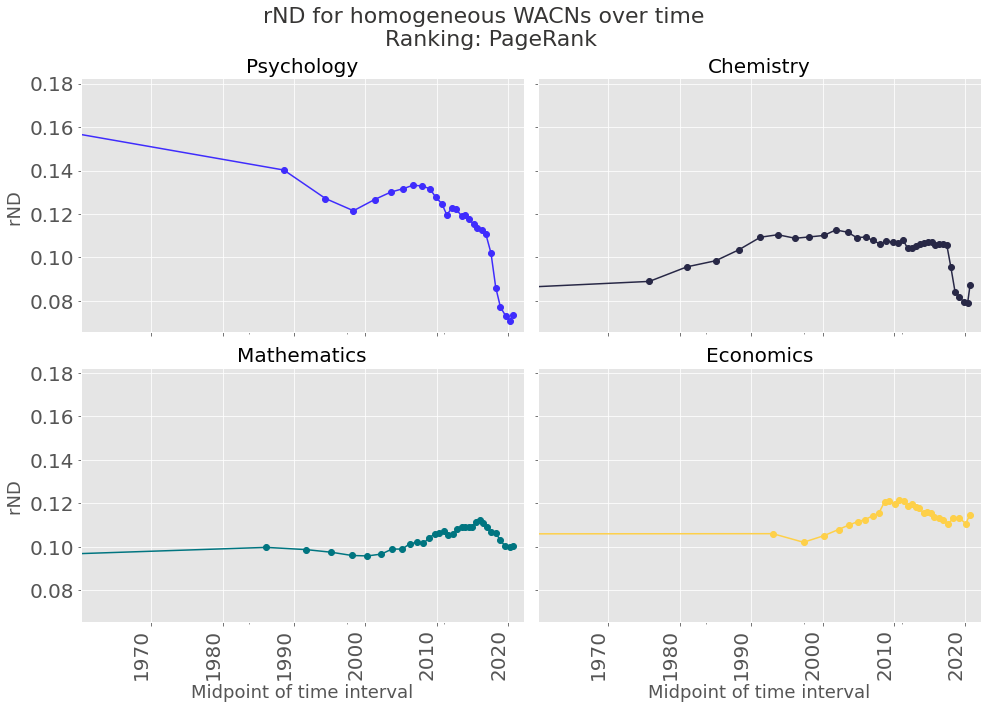

In [82]:
x = plot_slices(figsize=(14,10))